### Line Hough Transform

cv2使用代码参考：https://blog.csdn.net/qq_54185421/article/details/126661672

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""
  直接使用cv2的API：
"""
import cv2
import numpy as np

# 读取图像以及图像的宽和高
img_path = "/content/drive/MyDrive/CodeSpace/CUHK/CMSC_CV/HoughTransform​/example_1.png"
img = cv2.imread(img_path)
h, w = img.shape[:2]

# 求取图像的平均灰度值
img_gray = cv2.cvtColor(img, cv2.COLOR_RGBA2GRAY)
mean_gray = img_gray.mean()
print('图像的平均灰度值：', mean_gray)

# Canny算子寻找图像的边缘
image_edge = cv2.Canny(img, 200, 200)

# 寻找霍夫直线
# 1：像素之间的距离为1
# np.pi/180：直线角度范围，2pi/(pi/180) = 360°
# 180：一条预选直线上的最少像素点个数
lines = cv2.HoughLines(image_edge, 1, np.pi/180, 180)
print(f"found {len(lines)} lines(shape: {lines.shape}), \nsample[:3]=\n{lines[:3]}")

图像的平均灰度值： 24.619001885075402
found 46 lines(shape: (46, 1, 2)), 
sample[:3]=
[[[309.          1.6057029]]

 [[307.          1.6057029]]

 [[216.          1.7802358]]]


lines 返回值：[r, theta]
r 为(0, 0)到直线的距离, theta为垂线的角度

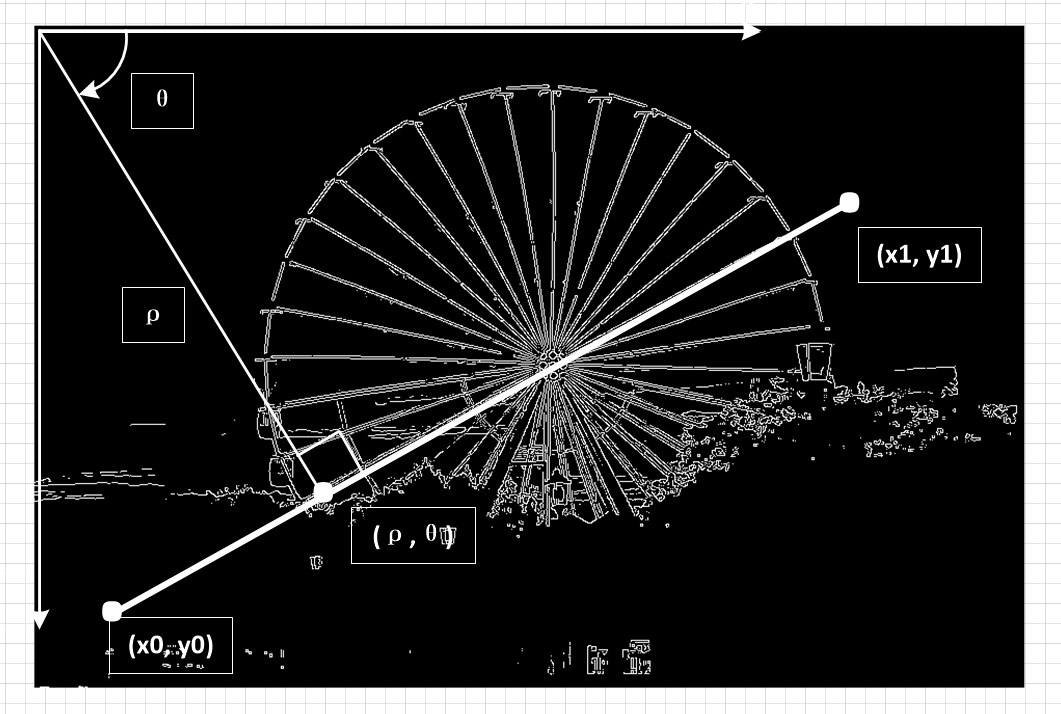

直线的数量： 46


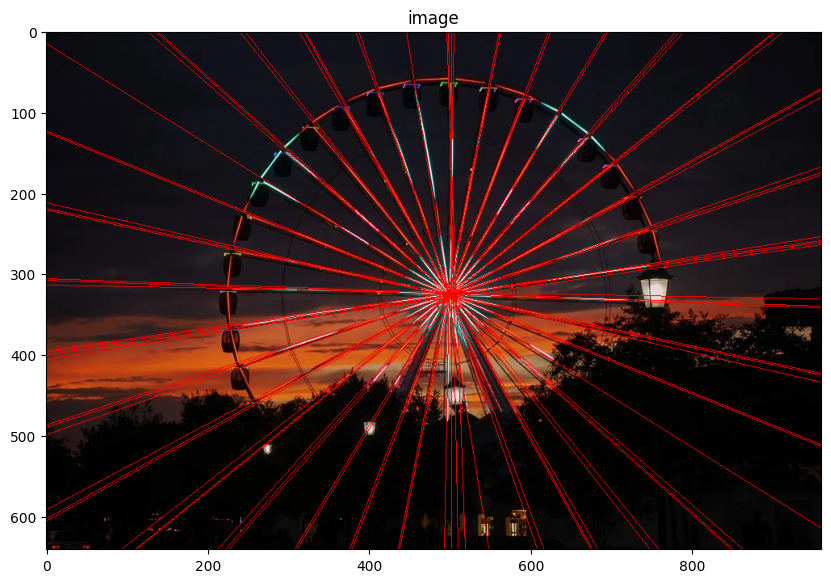

In [ ]:
import matplotlib.pyplot as plt
import cv2

# 绘画霍夫直线
if lines is not None:
    for n, line in enumerate(lines):
        # 沿着左上角的原点，作目标直线的垂线得到长度和角度
        rho = line[0][0]
        theta = line[0][1]
        # if np.pi / 3 < theta < np.pi * (3 / 4):
        a = np.cos(theta)
        b = np.sin(theta)
        # 得到目标直线上的点
        x0 = a * rho
        y0 = b * rho

        # 延长直线的长度，保证在整幅图像上绘制直线
        x1 = int(x0 + 2000 * (-b))
        y1 = int(y0 + 2000 * (a))
        x2 = int(x0 - 2000 * (-b))
        y2 = int(y0 - 2000 * (a))

        # 连接两点画直线
        # print((x1, y1), (x2, y2))  # (-148, 993) (335, -947)
        cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 1)

    print('直线的数量：', len(lines))
else:
    print('直线的数量：', 0)

# 可视化图像
plt.figure(figsize=(10,20))
# plt.subplot(1,2,1)
plt.title("image")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

### Line Hough 手写

代码参考：

  （1）https://blog.csdn.net/dielaoji0733/article/details/89634134

极坐标和直角坐标转换:

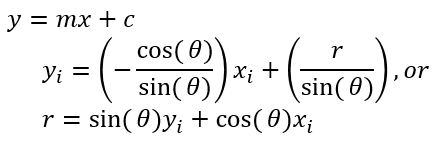


[(-45, 0), (-46, -1), (-44, 1)]


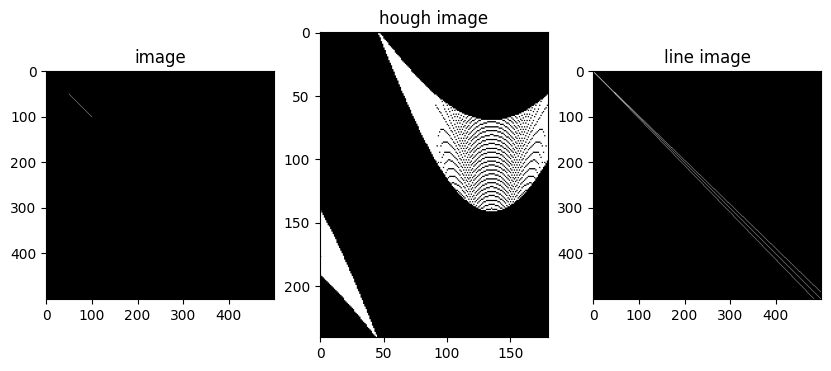

In [ ]:
"""
  手动实现一个Linea Hough Transform
"""

import cv2
import numpy as np


# 将角度转为弧度
def deg2rad(theta):
    return theta / 180 * np.pi

def my_hough_lines(key_points, threshold=0.5):

  # (1) 将key_points中的点转换到霍夫空间中，间隔的θ为1度，
  #     在笛卡尔坐标系中可以描述成在-90°到90°间以点为中心每隔1°画一条直线
  conver_points = []
  max_rho = -float('inf')
  min_rho = + float('inf')
  for key_point in key_points:  # 将点转换到霍夫空间
      conver_points_tmp = []
      for theta in range(-90, 90):  # 从-90°到90°打点，间隔1°
          x, y = key_point
          # r = x * cos(theta) + y * sin(theta)
          rho = x * np.cos(deg2rad(theta)) + y * np.sin(deg2rad(theta))
          conver_points_tmp.append((int(theta), int(rho)))
          if rho > max_rho:
            max_rho = rho
          if rho < min_rho:
            min_rho = rho
      conver_points.append(conver_points_tmp)

  # (2) 获取投票结果
  point_vote = {}
  for conver_point in conver_points:
      for point in conver_point:
          theta, rho = point
          key = f"{theta} {rho}"
          if key not in point_vote:
              point_vote[key] = 0
          point_vote[key] += 1
  sorted_votes = sorted(point_vote.items(), key=lambda d: d[1], reverse=True)
  max_hough = sorted_votes[0][1]

  # (3) 绘制换换到霍夫空间的曲线
  hough_img = np.zeros([int(max_rho-min_rho), 180]).astype(np.uint8)  # 转换成uint8的图像，否则imshow无法显示
  for conver_point in conver_points:  # 绘制霍夫空间的曲线
      for point in conver_point:
          theta, rho = point
          hough_img[rho][theta+90] = 255

  # (4) 返回结果
  result = []
  for vote in sorted_votes:
    if vote[1] > threshold * max_hough:
      result.append(vote)
  result = [tuple(map(int, res[0].split())) for res in result]
  return result, hough_img

# 绘制test图像（即初始化一个500*500的矩阵，并画上一条线）
img = np.zeros([500, 500]).astype(np.uint8)  # 创建一个矩阵
cv2.line(img, (50, 50), (100, 100), 255)  # 画直线
# cv2.imshow('', img)
# 将关键点，也就是线上的点放入key_points列表中
key_points = []
for y_cnt in range(0, 500):  # 将直线上的点取出（白点即像素值为255的点）
    for x_cnt in range(0, 500):
        if img[y_cnt][x_cnt] == 255:
            key_points.append((x_cnt, y_cnt))

lines, hough_img = my_hough_lines(key_points)
print(lines)

# 绘制结果
plt.figure(figsize=(10,20))

plt.subplot(1,3,1)
plt.title("image")
plt.imshow(img, "gray")

plt.subplot(1,3,2)
plt.title("hough image")
plt.imshow(hough_img, "gray")

result_img = np.zeros([500, 500]).astype(np.uint8)

for line in lines:
  theta, rho = line[:2]
  getY = lambda r, t, x: int((rho - x * np.cos(deg2rad(theta)))/np.sin(deg2rad(theta)))
  cv2.line(result_img, (0, getY(rho, theta, 0)), (500, getY(rho, theta, 500)), 255)  # 画直线

plt.subplot(1,3,3)
plt.title("line image")
plt.imshow(result_img, "gray")

### Circle Hough Transform



image shape=(293, 396)
found circles: 
[[[145.5 170.5  44.4]
  [292.5 177.5  44.4]
  [140.5 246.5  32.1]
  [173.5  83.5  44.1]
  [172.5  84.5  45.2]
  [146.5 167.5  42.1]
  [215.5 225.5  42.2]
  [174.5  84.5  44.4]
  [141.5 169.5  37.6]
  [218.5 228.5  37.8]
  [171.5  83.5  43. ]
  [142.5 170.5  36.6]
  [149.5 170.5  37.8]
  [173.5  85.5  41.1]]]


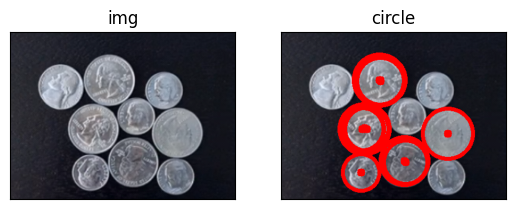

In [ ]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

# 读取图像以及图像的宽和高
img_path = "/content/drive/MyDrive/CodeSpace/CUHK/CMSC_CV/HoughTransform​/example_2.png"
img = cv2.imread(img_path)
h, w = img.shape[:2]
print(f"image shape={(h, w)}")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # 灰度图像

plt.subplot(121), plt.imshow(img, cmap='gray')
plt.title('img'), plt.xticks([]), plt.yticks([])
# hough transform  规定检测的圆的最大最小半径，不能盲目的检测，否则浪费时间空间
circle_hough = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, minDist=1, param1=100, param2=100, minRadius=5, maxRadius=100)
print(f"found circles: \n{circle_hough}")
circles = circle_hough[0, :, :]  # 提取为二维
circles = np.uint16(np.around(circles))  # 四舍五入，取整
for i in circles[:]:
    cv2.circle(img, (i[0], i[1]), i[2], (255, 0, 0), 5)  # 画圆
    cv2.circle(img, (i[0], i[1]), 2, (255, 0, 0), 10)  # 画圆心

plt.subplot(122), plt.imshow(img)
plt.title('circle'), plt.xticks([]), plt.yticks([])
plt.show()

### Circle Hough 手写



In [1]:
"""
  手动实现一个Linea Hough Transform
"""

import cv2
import numpy as np


# 将角度转为弧度
def deg2rad(theta):
    return theta / 180 * np.pi

def my_hough_circles(key_points, minRadius, maxRadius, threshold=0.5):

    # (1) 将key_points中的点转换到霍夫空间中，间隔的θ为1度，
    #     在笛卡尔坐标系中可以描述成在-90°到90°间以点为中心每隔1°画一条直线
    center_points = []
    for key_point in key_points:  # 将点转换到霍夫空间
        center_points_tmp = []
        for r in range(minRadius, maxRadius+1):  # 从-90°到90°打点，间隔1°
            x, y, theta = key_point[:3]
            cx = x - r * np.cos(deg2rad(theta))
            cy = y - r * np.sin(deg2rad(theta))
            center_points_tmp.append((int(cx), int(cy), int(r)))
        center_points.append(center_points_tmp)

    # (2) 获取投票结果
    point_vote = {}
    for conver_points in center_points:
        for center in conver_points:
            cx, cy, r = center
            key = f"{cx} {cy} {r}"
            if key not in point_vote:
                point_vote[key] = 0
            point_vote[key] += 1
    sorted_votes = sorted(point_vote.items(), key=lambda d: d[1], reverse=True)
    max_hough = sorted_votes[0][1]

    # # (3) 绘制换换到霍夫空间的曲线
    # hough_img = np.zeros([int(max_rho-min_rho), 180]).astype(np.uint8)  # 转换成uint8的图像，否则imshow无法显示
    # for conver_point in conver_points:  # 绘制霍夫空间的曲线
    #     for point in conver_point:
    #         theta, rho = point
    #         hough_img[rho][theta+90] = 255

    # (4) 返回结果
    result = []
    for vote in sorted_votes:
      if vote[1] > threshold * max_hough:
        result.append(vote)
    result = [tuple(map(int, res[0].split())) for res in result]
    return result

# 从图像中获取关键点（xi, yi, theta）
def get_key_points(image, threshold=1.0):

    # Sobel算子参数
    scale = 1
    delta = 0
    ddepth = cv2.CV_16S
    ksize = 3

    # 使用高斯模糊
    img = cv2.GaussianBlur(image, (5, 5), 1)
    # 转为灰度图
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 计算水平方向的 Sobel 梯度
    grad_x = cv2.Sobel(gray, ddepth, 1, 0, ksize=ksize, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    # 计算垂直方向的 Sobel 梯度
    grad_y = cv2.Sobel(gray, ddepth, 0, 1, ksize=ksize, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    # 将梯度图转换为8bitU图像（0~255）,如果计算后的值大于255，则将其取为255（8位最大值）
    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)
    # 将x,y方向的梯度图合为一张
    grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    orientation = np.arctan2(grad_y, grad_x)

    res_points = []
    h, w = grad.shape[:2]
    for y in range(h):
        for x in range(w):
            if grad[y][x] >= threshold * 255:
                res_points.append((x, y, orientation[y][x]))
    return res_points, grad

image shape=(293, 396)
found 255 key-points, grad_img=(293, 396)
found 47 circles


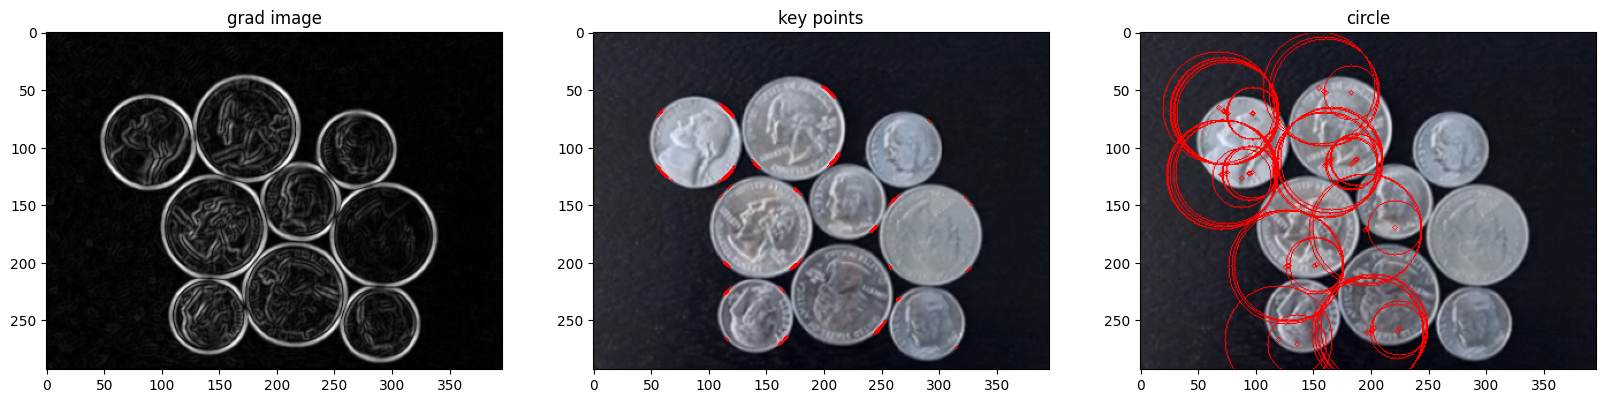

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import copy

# 读取图像以及图像的宽和高
img_path = "/content/drive/MyDrive/CodeSpace/CUHK/CMSC_CV/HoughTransform​/example_2.png"
img = cv2.imread(img_path)
h, w = img.shape[:2]
print(f"image shape={(h, w)}")

# 将关键点，也就是线上的点放入key_points列表中
key_points, grad = get_key_points(img, threshold=0.9)
print(f"found {len(key_points)} key-points, grad_img={grad.shape}")
img_points = copy.deepcopy(img)
for i in key_points[:]:
    cv2.circle(img_points, (i[0], i[1]), 1, (255, 0, 0), 1)  # 画关键点

# 根据关键点找出圆，绘图
circles = my_hough_circles(key_points, minRadius=5, maxRadius=50, threshold=0.9)
print(f"found {len(circles)} circles")
for i in circles[:]:
    # print(i)
    cv2.circle(img, (i[0], i[1]), i[2], (255, 0, 0), 1)  # 画圆
    cv2.circle(img, (i[0], i[1]), 2, (255, 0, 0), 1)  # 画圆心

plt.figure(figsize=(20,10))

plt.subplot(1, 3, 1), plt.imshow(grad, 'gray')
plt.title('grad image'),
plt.subplot(1, 3, 2), plt.imshow(img_points),
plt.title('key points'),
plt.subplot(1, 3, 3), plt.imshow(img)
plt.title('circle'),

plt.show()